# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [2]:
# Hier kann das Spiel übergeben werden
game = "Breakout-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [3]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [6]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [7]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [9]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

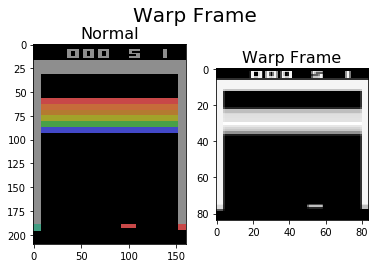

In [10]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [11]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

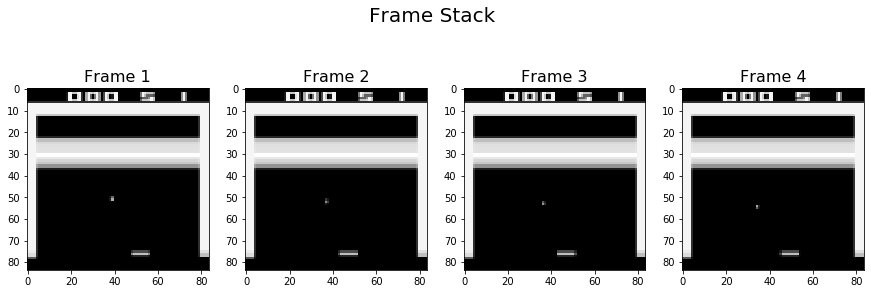

In [12]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
plt.show()

### Erstellen des Environments

In [13]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [14]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "mean_squared_error"#Huber()################################################################### MSE probieren
OPTIMIZER = Adam(lr=0.00005)#RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01) # Adam probieren mit 0.00005#############################

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [15]:
DQN.summary()
TARGET.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0     

# **Memory Buffer**

In [16]:
MEMORY_SIZE = 25000#1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 32#50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [17]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, batch_size=MINIBATCH_SIZE, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [18]:
def linear(epsilon, decay, epsilon_min, decay_step):
    return epsilon - decay

def exponential(epsilon, decay, epsilon_min, decay_step):
    epsilon = 1
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-decay * decay_step)

def epsilon_decay(mode, epsilon, decay, epsilon_min, decay_step):
    decay_strategy = {
        "linear": linear,
        "exponential": exponential
    }
    strategy = decay_strategy.get(mode)
    return strategy(epsilon, decay, epsilon_min, decay_step)

In [19]:
EPSILON = 1.0
EPSILON_MIN = 0.02 #0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.00002 #0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [20]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

3.0

# **Training des Agenten**

In [ ]:
from datetime import datetime
#start_time = datetime.now()

EPISODES = 12185#15000
#REWARD_LIST = []
#MEAN_LIST = []
#BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
#EPSILON_LIST = []
#STEPS = 0
#SYNC = 1000 #10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state
        STEPS += 1
        
        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            EPSILON = epsilon_decay("exponential", EPSILON, EPSILON_DECAY, EPSILON_MIN, STEPS)

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD, "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    PATH = "WEIGHTS"
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"/" + game + "_DQN"+ "_Ep_"+ str(episode+1)+ ".h5")
                    #TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_Ep_"+ str(episode+1)+ ".h5")
                    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Episode: 1 	Reward: 12.0 	Mean: 11.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020178289360403615
Episode: 2 	Reward: 7.0 	Mean: 10.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020177822853670035
Episode: 3 	Reward: 6.0 	Mean: 10.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020177435622084818
Episode: 4 	Reward: 10.0 	Mean: 9.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02017689703685801
Episode: 5 	Reward: 16.0 	Mean: 9.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02017603940299724
Episode: 6 	Reward: 17.0 	Mean: 10.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02017512287154186
Episode: 7 	Reward: 6.0 	Mean: 10.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020174692598730413
Episode: 8 	Reward: 12.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020174012624407163
Episode: 9 	Reward: 18.0 	Mean: 10.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020173065104561
Episode: 10 	Reward: 13.0 	Mean: 11.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02017172388216779
Episode: 11

Episode: 84 	Reward: 8.0 	Mean: 11.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02012704074358609
Episode: 85 	Reward: 8.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020126688060775166
Episode: 86 	Reward: 13.0 	Mean: 11.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020126184844358214
Episode: 87 	Reward: 10.0 	Mean: 11.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020125736424972396
Episode: 88 	Reward: 7.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020125414951386224
Episode: 89 	Reward: 6.0 	Mean: 9.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020125124325954865
Episode: 90 	Reward: 8.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020124776963386392
Episode: 91 	Reward: 9.0 	Mean: 9.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020124403193431492
Episode: 92 	Reward: 13.0 	Mean: 9.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020123852067657266
Episode: 93 	Reward: 10.0 	Mean: 9.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020123394661729722
Ep

Episode: 166 	Reward: 12.0 	Mean: 11.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020091638166582493
Episode: 167 	Reward: 12.0 	Mean: 11.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020091286950788715
Episode: 168 	Reward: 10.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020090898895522926
Episode: 169 	Reward: 15.0 	Mean: 11.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02009047629210052
Episode: 170 	Reward: 6.0 	Mean: 11.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020090230530972662
Episode: 171 	Reward: 11.0 	Mean: 10.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020089877519645492
Episode: 172 	Reward: 13.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020089361313234005
Episode: 173 	Reward: 10.0 	Mean: 11.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020089077595608035
Episode: 174 	Reward: 17.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020088656366905544
Episode: 175 	Reward: 6.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02

Episode: 247 	Reward: 11.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02006297437204213
Episode: 248 	Reward: 9.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020062785732027504
Episode: 249 	Reward: 10.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020062587642260966
Episode: 250 	Reward: 10.0 	Mean: 11.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020062385186455554
Episode: 251 	Reward: 7.0 	Mean: 11.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020062228173704844
Episode: 252 	Reward: 13.0 	Mean: 11.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020061976039498382
Episode: 253 	Reward: 17.0 	Mean: 11.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020061674333187774
Episode: 254 	Reward: 12.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020061452704758828
Episode: 255 	Reward: 12.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020061226974403913
Episode: 256 	Reward: 11.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02

Episode: 329 	Reward: 9.0 	Mean: 11.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020043465514372884
Episode: 330 	Reward: 13.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020043303256959626
Episode: 331 	Reward: 12.0 	Mean: 12.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020043126939603223
Episode: 332 	Reward: 15.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02004292557708171
Episode: 333 	Reward: 4.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020042844095916872
Episode: 334 	Reward: 12.0 	Mean: 10.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02004268245093579
Episode: 335 	Reward: 10.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020042528219790204
Episode: 336 	Reward: 20.0 	Mean: 12.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02004228057880214
Episode: 337 	Reward: 12.0 	Mean: 11.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020042117690344936
Episode: 338 	Reward: 10.0 	Mean: 11.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200

Episode: 410 	Reward: 15.0 	Mean: 11.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020030899742503435
Episode: 411 	Reward: 12.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02003078500899795
Episode: 412 	Reward: 14.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020030646787688657
Episode: 413 	Reward: 9.0 	Mean: 11.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02003054276554836
Episode: 414 	Reward: 12.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020030425097718355
Episode: 415 	Reward: 8.0 	Mean: 11.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020030326073397137
Episode: 416 	Reward: 3.0 	Mean: 11.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020030276984930626
Episode: 417 	Reward: 20.0 	Mean: 12.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200300459492225
Episode: 418 	Reward: 12.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020029941571042577
Episode: 419 	Reward: 7.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200298

Episode: 491 	Reward: 14.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02002230939411776
Episode: 492 	Reward: 12.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020022218557223036
Episode: 493 	Reward: 10.0 	Mean: 11.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020022144471034717
Episode: 494 	Reward: 12.0 	Mean: 11.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02002206048172554
Episode: 495 	Reward: 10.0 	Mean: 11.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020021978569185306
Episode: 496 	Reward: 12.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020021898712620594
Episode: 497 	Reward: 10.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020021822201099687
Episode: 498 	Reward: 14.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020021708586003335
Episode: 499 	Reward: 16.0 	Mean: 12.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020021599449983666
Episode: 500 	Reward: 10.0 	Mean: 12.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0

Episode: 573 	Reward: 17.0 	Mean: 11.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020015809133626654
Episode: 574 	Reward: 14.0 	Mean: 11.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020015732802290742
Episode: 575 	Reward: 10.0 	Mean: 11.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020015678460859707
Episode: 576 	Reward: 12.0 	Mean: 12.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020015533016428347
Episode: 577 	Reward: 9.0 	Mean: 12.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001548400956805
Episode: 578 	Reward: 12.0 	Mean: 12.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020015329634502865
Episode: 579 	Reward: 16.0 	Mean: 12.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020015258364593943
Episode: 580 	Reward: 7.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001521752692375
Episode: 581 	Reward: 13.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020015094159043057
Episode: 582 	Reward: 13.0 	Mean: 12.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020

Episode: 654 	Reward: 10.0 	Mean: 9.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001113182196716
Episode: 655 	Reward: 9.0 	Mean: 9.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020011096922866446
Episode: 656 	Reward: 11.0 	Mean: 9.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001102061765439
Episode: 657 	Reward: 11.0 	Mean: 9.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020010978379631502
Episode: 658 	Reward: 15.0 	Mean: 9.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001091707252568
Episode: 659 	Reward: 10.0 	Mean: 10.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020010880452717723
Episode: 660 	Reward: 12.0 	Mean: 10.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020010802826908286
Episode: 661 	Reward: 9.0 	Mean: 10.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020010769174613214
Episode: 662 	Reward: 13.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200107261839534
Episode: 663 	Reward: 10.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001068785

Episode: 736 	Reward: 9.0 	Mean: 9.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000802761803454
Episode: 737 	Reward: 9.0 	Mean: 9.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000798342766063
Episode: 738 	Reward: 14.0 	Mean: 10.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000794821877932
Episode: 739 	Reward: 11.0 	Mean: 10.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020007918706332645
Episode: 740 	Reward: 10.0 	Mean: 10.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020007860795819742
Episode: 741 	Reward: 14.0 	Mean: 10.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020007811116025603
Episode: 742 	Reward: 11.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020007781490109594
Episode: 743 	Reward: 14.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020007747016880708
Episode: 744 	Reward: 20.0 	Mean: 12.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200076662520905
Episode: 745 	Reward: 9.0 	Mean: 12.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020007642

Episode: 817 	Reward: 12.0 	Mean: 9.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020005764208502117
Episode: 818 	Reward: 6.0 	Mean: 9.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000574889608205
Episode: 819 	Reward: 5.0 	Mean: 8.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000573591824738
Episode: 820 	Reward: 10.0 	Mean: 8.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020005715763308653
Episode: 821 	Reward: 14.0 	Mean: 9.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000568975876339
Episode: 822 	Reward: 19.0 	Mean: 10.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000565809832426
Episode: 823 	Reward: 2.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000565142570586
Episode: 824 	Reward: 11.0 	Mean: 10.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020005632018201477
Episode: 825 	Reward: 7.0 	Mean: 9.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020005617393973888
Episode: 826 	Reward: 12.0 	Mean: 9.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200055844606162

Episode: 899 	Reward: 13.0 	Mean: 10.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020004089684593784
Episode: 900 	Reward: 10.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020004075069699208
Episode: 901 	Reward: 9.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020004062294048622
Episode: 902 	Reward: 10.0 	Mean: 9.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020004041548257637
Episode: 903 	Reward: 14.0 	Mean: 10.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020004013998395496
Episode: 904 	Reward: 8.0 	Mean: 10.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020004002374662707
Episode: 905 	Reward: 5.0 	Mean: 9.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020003994457801155
Episode: 906 	Reward: 12.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020003959935949025
Episode: 907 	Reward: 7.0 	Mean: 9.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020003945469073983
Episode: 908 	Reward: 12.0 	Mean: 10.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200039

Episode: 981 	Reward: 10.0 	Mean: 12.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020002913945050854
Episode: 982 	Reward: 10.0 	Mean: 11.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200029045191471
Episode: 983 	Reward: 12.0 	Mean: 11.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020002884258508036
Episode: 984 	Reward: 10.0 	Mean: 11.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020002874986132176
Episode: 985 	Reward: 11.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020002861276490612
Episode: 986 	Reward: 8.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020002814452786385
Episode: 987 	Reward: 8.0 	Mean: 10.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020002806583340946
Episode: 988 	Reward: 12.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000279593856214
Episode: 989 	Reward: 11.0 	Mean: 10.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020002784888538922
Episode: 990 	Reward: 12.0 	Mean: 10.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200

Episode: 1062 	Reward: 12.0 	Mean: 12.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000200805752765
Episode: 1063 	Reward: 14.0 	Mean: 12.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020001998921630997
Episode: 1064 	Reward: 12.0 	Mean: 12.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000199066320219
Episode: 1065 	Reward: 15.0 	Mean: 12.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000196687866195
Episode: 1066 	Reward: 10.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020001960437868616
Episode: 1067 	Reward: 12.0 	Mean: 12.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200019539009289
Episode: 1068 	Reward: 6.0 	Mean: 11.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02000194956808008
Episode: 1069 	Reward: 16.0 	Mean: 12.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020001940193772164
Episode: 1070 	Reward: 8.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020001934884917683
Episode: 1071 	Reward: 19.0 	Mean: 12.4 	BestMean: 13.7 	TRAIN START: True 	Epsi:

Episode: 1143 	Reward: 10.0 	Mean: 13.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020001391563382407
Episode: 1144 	Reward: 14.0 	Mean: 13.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020001385897370334
Episode: 1145 	Reward: 10.0 	Mean: 12.9 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020001380944728267
Episode: 1146 	Reward: 9.0 	Mean: 12.3 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020001376560298968
Episode: 1147 	Reward: 8.0 	Mean: 11.7 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000137240935794
Episode: 1148 	Reward: 11.0 	Mean: 10.5 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000136777844496
Episode: 1149 	Reward: 12.0 	Mean: 10.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000136210030535
Episode: 1150 	Reward: 8.0 	Mean: 10.4 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020001358481933105
Episode: 1151 	Reward: 12.0 	Mean: 10.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020001353491906872
Episode: 1152 	Reward: 15.0 	Mean: 10.9 	BestMean: 14.1 	TRAIN START: True 	Eps

Episode: 1224 	Reward: 11.0 	Mean: 11.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000100914945333
Episode: 1225 	Reward: 14.0 	Mean: 11.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020001004236800617
Episode: 1226 	Reward: 15.0 	Mean: 12.3 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000999507971733
Episode: 1227 	Reward: 11.0 	Mean: 12.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000995657307525
Episode: 1228 	Reward: 13.0 	Mean: 12.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000991543807092
Episode: 1229 	Reward: 17.0 	Mean: 12.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000098667739276
Episode: 1230 	Reward: 15.0 	Mean: 12.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000098218838656
Episode: 1231 	Reward: 17.0 	Mean: 13.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000977680695618
Episode: 1232 	Reward: 9.0 	Mean: 13.4 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000974986017266
Episode: 1233 	Reward: 10.0 	Mean: 13.2 	BestMean: 14.1 	TRAIN START: True 	E

Episode: 1305 	Reward: 12.0 	Mean: 13.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000721969669948
Episode: 1306 	Reward: 11.0 	Mean: 13.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000719447193015
Episode: 1307 	Reward: 10.0 	Mean: 12.7 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000071711995627
Episode: 1308 	Reward: 8.0 	Mean: 12.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000713843056697
Episode: 1309 	Reward: 10.0 	Mean: 11.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000711605104922
Episode: 1310 	Reward: 11.0 	Mean: 11.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000708920315073
Episode: 1311 	Reward: 15.0 	Mean: 11.3 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000070563854441
Episode: 1312 	Reward: 17.0 	Mean: 11.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000070199278741
Episode: 1313 	Reward: 19.0 	Mean: 12.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000698477614084
Episode: 1314 	Reward: 13.0 	Mean: 12.6 	BestMean: 14.1 	TRAIN START: True 	E

Episode: 1386 	Reward: 7.0 	Mean: 10.4 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000528690465716
Episode: 1387 	Reward: 7.0 	Mean: 10.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000052690650853
Episode: 1388 	Reward: 11.0 	Mean: 10.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000521747174038
Episode: 1389 	Reward: 13.0 	Mean: 10.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000519570822595
Episode: 1390 	Reward: 8.0 	Mean: 9.8 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000518169873506
Episode: 1391 	Reward: 7.0 	Mean: 9.5 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000516907080247
Episode: 1392 	Reward: 16.0 	Mean: 10.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000051440100653
Episode: 1393 	Reward: 12.0 	Mean: 10.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000051260375004
Episode: 1394 	Reward: 13.0 	Mean: 10.5 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000508458261054
Episode: 1395 	Reward: 11.0 	Mean: 10.5 	BestMean: 14.1 	TRAIN START: True 	Epsi: 

Episode: 1467 	Reward: 6.0 	Mean: 10.9 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000370362823653
Episode: 1468 	Reward: 11.0 	Mean: 11.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000368995013215
Episode: 1469 	Reward: 13.0 	Mean: 11.7 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000036761754933
Episode: 1470 	Reward: 10.0 	Mean: 11.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000366487029173
Episode: 1471 	Reward: 8.0 	Mean: 11.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000365528089915
Episode: 1472 	Reward: 8.0 	Mean: 10.4 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000364440437613
Episode: 1473 	Reward: 11.0 	Mean: 10.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000363152599284
Episode: 1474 	Reward: 13.0 	Mean: 10.7 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000361500393325
Episode: 1475 	Reward: 13.0 	Mean: 10.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000359718985082
Episode: 1476 	Reward: 8.0 	Mean: 10.1 	BestMean: 14.1 	TRAIN START: True 	Ep

Episode: 1548 	Reward: 8.0 	Mean: 12.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000259641836562
Episode: 1549 	Reward: 6.0 	Mean: 11.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000259045346563
Episode: 1550 	Reward: 14.0 	Mean: 11.8 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000257053216005
Episode: 1551 	Reward: 8.0 	Mean: 11.8 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000256308841544
Episode: 1552 	Reward: 14.0 	Mean: 12.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000255173352938
Episode: 1553 	Reward: 14.0 	Mean: 11.5 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000253768676503
Episode: 1554 	Reward: 11.0 	Mean: 12.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000252876981067
Episode: 1555 	Reward: 5.0 	Mean: 10.9 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000252356590673
Episode: 1556 	Reward: 8.0 	Mean: 10.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000251047742355
Episode: 1557 	Reward: 11.0 	Mean: 9.9 	BestMean: 14.1 	TRAIN START: True 	Eps

Episode: 1629 	Reward: 13.0 	Mean: 12.3 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000181875635056
Episode: 1630 	Reward: 15.0 	Mean: 11.9 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000181015584474
Episode: 1631 	Reward: 12.0 	Mean: 12.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000180249703212
Episode: 1632 	Reward: 15.0 	Mean: 12.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000017943322437
Episode: 1633 	Reward: 13.0 	Mean: 12.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000017869548028
Episode: 1634 	Reward: 8.0 	Mean: 12.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000178213653245
Episode: 1635 	Reward: 13.0 	Mean: 13.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02000017743123575
Episode: 1636 	Reward: 12.0 	Mean: 13.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000176804239614
Episode: 1637 	Reward: 7.0 	Mean: 12.4 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000176320459077
Episode: 1638 	Reward: 2.0 	Mean: 11.0 	BestMean: 14.1 	TRAIN START: True 	Eps

Episode: 1710 	Reward: 4.0 	Mean: 11.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000127653955417
Episode: 1711 	Reward: 13.0 	Mean: 11.8 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000127139273793
Episode: 1712 	Reward: 11.0 	Mean: 11.7 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000126401472307
Episode: 1713 	Reward: 14.0 	Mean: 11.8 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000125823877266
Episode: 1714 	Reward: 5.0 	Mean: 11.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000125580015564
Episode: 1715 	Reward: 11.0 	Mean: 10.8 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000125136248242
Episode: 1716 	Reward: 7.0 	Mean: 10.4 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000124803828137
Episode: 1717 	Reward: 11.0 	Mean: 10.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000124327986948
Episode: 1718 	Reward: 12.0 	Mean: 10.3 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.020000123836621666
Episode: 1719 	Reward: 17.0 	Mean: 10.5 	BestMean: 14.1 	TRAIN START: True 	

Episode: 1790 	Reward: 13.0 	Mean: 10.5 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000090882106136
Episode: 1791 	Reward: 15.0 	Mean: 11.3 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.02000009047586496
Episode: 1792 	Reward: 9.0 	Mean: 11.3 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000090199431973
Episode: 1793 	Reward: 12.0 	Mean: 11.3 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000088337360746
Episode: 1794 	Reward: 14.0 	Mean: 11.6 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000087977678566
Episode: 1795 	Reward: 11.0 	Mean: 11.7 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000087663281582
Episode: 1796 	Reward: 11.0 	Mean: 12.0 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000087355249285
Episode: 1797 	Reward: 19.0 	Mean: 12.9 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000086865689735
Episode: 1798 	Reward: 13.0 	Mean: 12.8 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000086517190617
Episode: 1799 	Reward: 10.0 	Mean: 12.7 	BestMean: 14.7 	TRAIN START: True 

Episode: 1871 	Reward: 11.0 	Mean: 11.8 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000063114032483
Episode: 1872 	Reward: 16.0 	Mean: 12.5 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.02000006280553017
Episode: 1873 	Reward: 10.0 	Mean: 12.1 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.02000006257858517
Episode: 1874 	Reward: 9.0 	Mean: 11.9 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000062396122228
Episode: 1875 	Reward: 13.0 	Mean: 12.3 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.02000006214703624
Episode: 1876 	Reward: 16.0 	Mean: 13.3 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000061681443353
Episode: 1877 	Reward: 11.0 	Mean: 12.9 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000061447498645
Episode: 1878 	Reward: 7.0 	Mean: 12.4 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000061298975483
Episode: 1879 	Reward: 8.0 	Mean: 12.0 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000061137359613
Episode: 1880 	Reward: 15.0 	Mean: 11.6 	BestMean: 14.7 	TRAIN START: True 	Eps

Episode: 1952 	Reward: 14.0 	Mean: 10.9 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.0200000446245042
Episode: 1953 	Reward: 17.0 	Mean: 11.3 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.02000004439128337
Episode: 1954 	Reward: 10.0 	Mean: 11.1 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.0200000442529984
Episode: 1955 	Reward: 6.0 	Mean: 10.6 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.02000004414338694
Episode: 1956 	Reward: 15.0 	Mean: 11.8 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000043957494357
Episode: 1957 	Reward: 12.0 	Mean: 12.2 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.02000004374262948
Episode: 1958 	Reward: 16.0 	Mean: 12.3 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.02000004352446221
Episode: 1959 	Reward: 8.0 	Mean: 12.4 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.020000043394084486
Episode: 1960 	Reward: 25.0 	Mean: 13.9 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.02000004297433726
Episode: 1961 	Reward: 9.0 	Mean: 13.2 	BestMean: 14.7 	TRAIN START: True 	Epsi: 0.0

Episode: 2033 	Reward: 12.0 	Mean: 12.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000031368466276
Episode: 2034 	Reward: 11.0 	Mean: 13.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0200000312494923
Episode: 2035 	Reward: 10.0 	Mean: 13.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000031140310258
Episode: 2036 	Reward: 10.0 	Mean: 13.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000031015377492
Episode: 2037 	Reward: 11.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000030902068693
Episode: 2038 	Reward: 13.0 	Mean: 12.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000030767013618
Episode: 2039 	Reward: 14.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000030639901484
Episode: 2040 	Reward: 11.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000003053590272
Episode: 2041 	Reward: 13.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000030402447945
Episode: 2042 	Reward: 11.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	

Episode: 2114 	Reward: 10.0 	Mean: 12.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000022552888023
Episode: 2115 	Reward: 12.0 	Mean: 12.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000022457915368
Episode: 2116 	Reward: 11.0 	Mean: 12.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000002237542212
Episode: 2117 	Reward: 14.0 	Mean: 12.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000022184705937
Episode: 2118 	Reward: 9.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000002211869392
Episode: 2119 	Reward: 12.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000021961328905
Episode: 2120 	Reward: 16.0 	Mean: 12.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000021857041382
Episode: 2121 	Reward: 12.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000002176717562
Episode: 2122 	Reward: 12.0 	Mean: 12.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000002168895467
Episode: 2123 	Reward: 9.0 	Mean: 11.7 	BestMean: 15.2 	TRAIN START: True 	Eps

Episode: 2195 	Reward: 7.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000001597528962
Episode: 2196 	Reward: 8.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000001592138429
Episode: 2197 	Reward: 11.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000001586131506
Episode: 2198 	Reward: 14.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000001579483724
Episode: 2199 	Reward: 12.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000015708204096
Episode: 2200 	Reward: 16.0 	Mean: 11.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000015632672726
Episode: 2201 	Reward: 13.0 	Mean: 12.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000015569332744
Episode: 2202 	Reward: 15.0 	Mean: 12.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000015493539487
Episode: 2203 	Reward: 15.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000015421815988
Episode: 2204 	Reward: 8.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi

Episode: 2276 	Reward: 7.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000001141516951
Episode: 2277 	Reward: 14.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000001136437122
Episode: 2278 	Reward: 15.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000001131447783
Episode: 2279 	Reward: 10.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000001127832937
Episode: 2280 	Reward: 9.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0200000112422964
Episode: 2281 	Reward: 14.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000011188015154
Episode: 2282 	Reward: 12.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000011145804283
Episode: 2283 	Reward: 10.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000011107084298
Episode: 2284 	Reward: 6.0 	Mean: 10.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000001108245392
Episode: 2285 	Reward: 7.0 	Mean: 10.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.

Episode: 2357 	Reward: 12.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000807815197
Episode: 2358 	Reward: 9.0 	Mean: 10.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000008049927857
Episode: 2359 	Reward: 12.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000801939618
Episode: 2360 	Reward: 12.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000798514651
Episode: 2361 	Reward: 9.0 	Mean: 10.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000007961067746
Episode: 2362 	Reward: 15.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000792421396
Episode: 2363 	Reward: 12.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000007891475526
Episode: 2364 	Reward: 6.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000007873975885
Episode: 2365 	Reward: 9.0 	Mean: 10.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000782969166
Episode: 2366 	Reward: 10.0 	Mean: 10.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 

Episode: 2438 	Reward: 9.0 	Mean: 10.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000574932887
Episode: 2439 	Reward: 15.0 	Mean: 10.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000005725003323
Episode: 2440 	Reward: 14.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000005672234488
Episode: 2441 	Reward: 8.0 	Mean: 10.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0200000056554695
Episode: 2442 	Reward: 9.0 	Mean: 10.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000005638528513
Episode: 2443 	Reward: 8.0 	Mean: 9.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000005621525846
Episode: 2444 	Reward: 19.0 	Mean: 10.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000005592257935
Episode: 2445 	Reward: 8.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000005576733048
Episode: 2446 	Reward: 14.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0200000055452579
Episode: 2447 	Reward: 9.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0

Episode: 2519 	Reward: 16.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000003902366368
Episode: 2520 	Reward: 9.0 	Mean: 10.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000003889509784
Episode: 2521 	Reward: 8.0 	Mean: 10.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000003877315875
Episode: 2522 	Reward: 13.0 	Mean: 10.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000003861760353
Episode: 2523 	Reward: 12.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000003846651886
Episode: 2524 	Reward: 11.0 	Mean: 10.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000383129601
Episode: 2525 	Reward: 10.0 	Mean: 10.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000003817833557
Episode: 2526 	Reward: 9.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000380586436
Episode: 2527 	Reward: 13.0 	Mean: 10.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000379029226
Episode: 2528 	Reward: 16.0 	Mean: 11.7 	BestMean: 15.2 	TRAIN START: True 	Eps

Episode: 2600 	Reward: 12.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000276943445
Episode: 2601 	Reward: 10.0 	Mean: 12.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000002759758374
Episode: 2602 	Reward: 23.0 	Mean: 14.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000002742975087
Episode: 2603 	Reward: 7.0 	Mean: 13.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000002735469622
Episode: 2604 	Reward: 11.0 	Mean: 13.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000002725639638
Episode: 2605 	Reward: 17.0 	Mean: 14.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0200000027118285
Episode: 2606 	Reward: 12.0 	Mean: 14.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000002701164914
Episode: 2607 	Reward: 8.0 	Mean: 13.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000269226576
Episode: 2608 	Reward: 13.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000002681947286
Episode: 2609 	Reward: 17.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Eps

Episode: 2680 	Reward: 14.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001967302134
Episode: 2681 	Reward: 11.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001960428615
Episode: 2682 	Reward: 12.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001952797834
Episode: 2683 	Reward: 11.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001945235657
Episode: 2684 	Reward: 8.0 	Mean: 10.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001939292335
Episode: 2685 	Reward: 14.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000193104852
Episode: 2686 	Reward: 11.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000192418621
Episode: 2687 	Reward: 8.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001919266593
Episode: 2688 	Reward: 14.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000191053466
Episode: 2689 	Reward: 9.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Eps

Episode: 2761 	Reward: 8.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001369496468
Episode: 2762 	Reward: 18.0 	Mean: 12.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001362257335
Episode: 2763 	Reward: 6.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000135937241
Episode: 2764 	Reward: 13.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001354243683
Episode: 2765 	Reward: 16.0 	Mean: 12.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001330723965
Episode: 2766 	Reward: 10.0 	Mean: 12.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001322366758
Episode: 2767 	Reward: 7.0 	Mean: 11.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000131901221
Episode: 2768 	Reward: 10.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001314666643
Episode: 2769 	Reward: 9.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000001310676124
Episode: 2770 	Reward: 10.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Eps

Episode: 2841 	Reward: 17.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000098071158
Episode: 2842 	Reward: 10.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000976991946
Episode: 2843 	Reward: 8.0 	Mean: 12.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000974260194
Episode: 2844 	Reward: 9.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000965396027
Episode: 2845 	Reward: 9.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000961830664
Episode: 2846 	Reward: 7.0 	Mean: 10.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000095942909
Episode: 2847 	Reward: 12.0 	Mean: 10.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000095590488
Episode: 2848 	Reward: 16.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0200000009504337
Episode: 2849 	Reward: 10.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000094737823
Episode: 2850 	Reward: 13.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0

Episode: 2922 	Reward: 12.0 	Mean: 10.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000066919695
Episode: 2923 	Reward: 14.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000666472187
Episode: 2924 	Reward: 13.0 	Mean: 11.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000066387801
Episode: 2925 	Reward: 10.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000661862884
Episode: 2926 	Reward: 11.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000659431704
Episode: 2927 	Reward: 12.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000652087273
Episode: 2928 	Reward: 12.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000649730985
Episode: 2929 	Reward: 12.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000646891388
Episode: 2930 	Reward: 13.0 	Mean: 11.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000644089962
Episode: 2931 	Reward: 12.0 	Mean: 12.1 	BestMean: 15.2 	TRAIN START: True 

Episode: 3002 	Reward: 13.0 	Mean: 12.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000468744766
Episode: 3003 	Reward: 18.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000466239013
Episode: 3004 	Reward: 12.0 	Mean: 12.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000046445209
Episode: 3005 	Reward: 14.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000460778943
Episode: 3006 	Reward: 9.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000045938949
Episode: 3007 	Reward: 9.0 	Mean: 12.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000457564754
Episode: 3008 	Reward: 8.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000456285364
Episode: 3009 	Reward: 12.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000454636596
Episode: 3010 	Reward: 11.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000453066272
Episode: 3011 	Reward: 13.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Ep

Episode: 3083 	Reward: 17.0 	Mean: 14.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000032342214
Episode: 3084 	Reward: 8.0 	Mean: 14.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000322459778
Episode: 3085 	Reward: 14.0 	Mean: 14.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000320537222
Episode: 3086 	Reward: 15.0 	Mean: 14.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000031881099
Episode: 3087 	Reward: 13.0 	Mean: 13.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000317493837
Episode: 3088 	Reward: 9.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000316580772
Episode: 3089 	Reward: 7.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000031529806
Episode: 3090 	Reward: 12.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000314045665
Episode: 3091 	Reward: 14.0 	Mean: 12.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000312391877
Episode: 3092 	Reward: 12.0 	Mean: 12.1 	BestMean: 15.2 	TRAIN START: True 	Eps

Episode: 3163 	Reward: 16.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000022407446
Episode: 3164 	Reward: 14.0 	Mean: 13.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000222062397
Episode: 3165 	Reward: 13.0 	Mean: 13.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000022122016
Episode: 3166 	Reward: 11.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000220099214
Episode: 3167 	Reward: 9.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000219448682
Episode: 3168 	Reward: 9.0 	Mean: 12.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000218808826
Episode: 3169 	Reward: 8.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000218223204
Episode: 3170 	Reward: 10.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000217434664
Episode: 3171 	Reward: 13.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000216532015
Episode: 3172 	Reward: 12.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Ep

Episode: 3244 	Reward: 11.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000016076737
Episode: 3245 	Reward: 18.0 	Mean: 12.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000015993355
Episode: 3246 	Reward: 13.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000015901498
Episode: 3247 	Reward: 15.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000156691424
Episode: 3248 	Reward: 12.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000156109615
Episode: 3249 	Reward: 11.0 	Mean: 13.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000155589077
Episode: 3250 	Reward: 13.0 	Mean: 13.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000154281432
Episode: 3251 	Reward: 12.0 	Mean: 13.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000153662465
Episode: 3252 	Reward: 15.0 	Mean: 13.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000152981715
Episode: 3253 	Reward: 10.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	

Episode: 3324 	Reward: 14.0 	Mean: 12.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000011044729
Episode: 3325 	Reward: 18.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000109861273
Episode: 3326 	Reward: 14.0 	Mean: 13.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000010938332
Episode: 3327 	Reward: 16.0 	Mean: 13.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000010882253
Episode: 3328 	Reward: 10.0 	Mean: 13.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000108477026
Episode: 3329 	Reward: 11.0 	Mean: 13.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000108100182
Episode: 3330 	Reward: 9.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000010773542
Episode: 3331 	Reward: 12.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000010729461
Episode: 3332 	Reward: 7.0 	Mean: 12.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000106785102
Episode: 3333 	Reward: 16.0 	Mean: 12.7 	BestMean: 15.2 	TRAIN START: True 	Epsi

Episode: 3405 	Reward: 10.0 	Mean: 13.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000007695635
Episode: 3406 	Reward: 7.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000076450114
Episode: 3407 	Reward: 13.0 	Mean: 12.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000076077946
Episode: 3408 	Reward: 13.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000075601675
Episode: 3409 	Reward: 11.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000075326985
Episode: 3410 	Reward: 9.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000075101342
Episode: 3411 	Reward: 13.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000074783586
Episode: 3412 	Reward: 11.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000074459727
Episode: 3413 	Reward: 14.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000074144687
Episode: 3414 	Reward: 13.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	

Episode: 3486 	Reward: 12.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000055041003
Episode: 3487 	Reward: 14.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000005481251
Episode: 3488 	Reward: 10.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000054623185
Episode: 3489 	Reward: 14.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000054400776
Episode: 3490 	Reward: 14.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000054096984
Episode: 3491 	Reward: 9.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000005392523
Episode: 3492 	Reward: 8.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000053767997
Episode: 3493 	Reward: 14.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000053043823
Episode: 3494 	Reward: 10.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000052821505
Episode: 3495 	Reward: 13.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	E

Episode: 3567 	Reward: 7.0 	Mean: 9.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000038612593
Episode: 3568 	Reward: 10.0 	Mean: 9.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000003848153
Episode: 3569 	Reward: 7.0 	Mean: 8.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000038386215
Episode: 3570 	Reward: 8.0 	Mean: 8.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000038058272
Episode: 3571 	Reward: 9.0 	Mean: 8.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000037935162
Episode: 3572 	Reward: 14.0 	Mean: 9.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000037755775
Episode: 3573 	Reward: 11.0 	Mean: 9.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000037627624
Episode: 3574 	Reward: 14.0 	Mean: 10.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000037460927
Episode: 3575 	Reward: 8.0 	Mean: 9.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000003734871
Episode: 3576 	Reward: 10.0 	Mean: 9.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000

Episode: 3648 	Reward: 13.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000027055178
Episode: 3649 	Reward: 11.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000026882042
Episode: 3650 	Reward: 15.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000026738872
Episode: 3651 	Reward: 14.0 	Mean: 12.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000002637452
Episode: 3652 	Reward: 10.0 	Mean: 12.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000026286577
Episode: 3653 	Reward: 12.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000026137693
Episode: 3654 	Reward: 13.0 	Mean: 12.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000026023458
Episode: 3655 	Reward: 13.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000025899883
Episode: 3656 	Reward: 12.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000025798555
Episode: 3657 	Reward: 9.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 

Episode: 3729 	Reward: 13.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000018279833
Episode: 3730 	Reward: 18.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000018183934
Episode: 3731 	Reward: 10.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000018121127
Episode: 3732 	Reward: 17.0 	Mean: 13.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000001802606
Episode: 3733 	Reward: 16.0 	Mean: 13.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000001794656
Episode: 3734 	Reward: 16.0 	Mean: 13.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000001767442
Episode: 3735 	Reward: 18.0 	Mean: 14.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000017583456
Episode: 3736 	Reward: 10.0 	Mean: 14.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000001752798
Episode: 3737 	Reward: 14.0 	Mean: 14.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000001745207
Episode: 3738 	Reward: 12.0 	Mean: 14.4 	BestMean: 15.2 	TRAIN START: True 	Ep

Episode: 3810 	Reward: 11.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000001254119
Episode: 3811 	Reward: 12.0 	Mean: 10.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000012490127
Episode: 3812 	Reward: 19.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000012422366
Episode: 3813 	Reward: 10.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000001234361
Episode: 3814 	Reward: 8.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000012310327
Episode: 3815 	Reward: 11.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000012265352
Episode: 3816 	Reward: 13.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000012214192
Episode: 3817 	Reward: 10.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000012172975
Episode: 3818 	Reward: 11.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000012130204
Episode: 3819 	Reward: 10.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	

Episode: 3890 	Reward: 11.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000008616667
Episode: 3891 	Reward: 15.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000008578666
Episode: 3892 	Reward: 17.0 	Mean: 12.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000008534344
Episode: 3893 	Reward: 18.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000008473965
Episode: 3894 	Reward: 15.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000008429
Episode: 3895 	Reward: 15.0 	Mean: 13.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000008390823
Episode: 3896 	Reward: 8.0 	Mean: 13.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000008367862
Episode: 3897 	Reward: 11.0 	Mean: 13.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000008334958
Episode: 3898 	Reward: 11.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000830484
Episode: 3899 	Reward: 6.0 	Mean: 12.7 	BestMean: 15.2 	TRAIN START: True 	Eps

Episode: 3971 	Reward: 11.0 	Mean: 10.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000594802
Episode: 3972 	Reward: 8.0 	Mean: 10.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000005930916
Episode: 3973 	Reward: 8.0 	Mean: 10.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000591374
Episode: 3974 	Reward: 13.0 	Mean: 10.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000005889897
Episode: 3975 	Reward: 6.0 	Mean: 9.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000587672
Episode: 3976 	Reward: 14.0 	Mean: 9.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000585279
Episode: 3977 	Reward: 11.0 	Mean: 10.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000582686
Episode: 3978 	Reward: 12.0 	Mean: 10.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000580267
Episode: 3979 	Reward: 11.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000578182
Episode: 3980 	Reward: 13.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0

Episode: 4052 	Reward: 19.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000004131657
Episode: 4053 	Reward: 11.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000411656
Episode: 4054 	Reward: 10.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000410218
Episode: 4055 	Reward: 5.0 	Mean: 12.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000004094392
Episode: 4056 	Reward: 13.0 	Mean: 12.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000004048144
Episode: 4057 	Reward: 13.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000004030856
Episode: 4058 	Reward: 14.0 	Mean: 12.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000003999697
Episode: 4059 	Reward: 17.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000003979668
Episode: 4060 	Reward: 11.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000003964655
Episode: 4061 	Reward: 17.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	

Episode: 4133 	Reward: 14.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000002896718
Episode: 4134 	Reward: 10.0 	Mean: 10.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0200000000028881
Episode: 4135 	Reward: 8.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000288037
Episode: 4136 	Reward: 10.0 	Mean: 10.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000002871166
Episode: 4137 	Reward: 14.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000002844246
Episode: 4138 	Reward: 11.0 	Mean: 10.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000002834084
Episode: 4139 	Reward: 11.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000002824182
Episode: 4140 	Reward: 13.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000002813413
Episode: 4141 	Reward: 14.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000280011
Episode: 4142 	Reward: 14.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Ep

Episode: 4214 	Reward: 11.0 	Mean: 10.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000002031997
Episode: 4215 	Reward: 5.0 	Mean: 10.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000202741
Episode: 4216 	Reward: 17.0 	Mean: 10.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000002014514
Episode: 4217 	Reward: 11.0 	Mean: 9.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000200796
Episode: 4218 	Reward: 12.0 	Mean: 10.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000001998662
Episode: 4219 	Reward: 9.0 	Mean: 10.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000001993236
Episode: 4220 	Reward: 13.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000001985038
Episode: 4221 	Reward: 16.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000197502
Episode: 4222 	Reward: 15.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000001942388
Episode: 4223 	Reward: 13.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Eps

Episode: 4295 	Reward: 6.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000141932
Episode: 4296 	Reward: 10.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000141439
Episode: 4297 	Reward: 11.0 	Mean: 10.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000140928
Episode: 4298 	Reward: 10.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000140441
Episode: 4299 	Reward: 11.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000139945
Episode: 4300 	Reward: 14.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000139375
Episode: 4301 	Reward: 15.0 	Mean: 10.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000138716
Episode: 4302 	Reward: 13.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000001381347
Episode: 4303 	Reward: 12.0 	Mean: 10.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000001375667
Episode: 4304 	Reward: 16.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi:

Episode: 4376 	Reward: 10.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000001012416
Episode: 4377 	Reward: 8.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0200000000010091
Episode: 4378 	Reward: 13.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000001004912
Episode: 4379 	Reward: 14.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000100062
Episode: 4380 	Reward: 9.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000099764
Episode: 4381 	Reward: 12.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000993678
Episode: 4382 	Reward: 13.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0200000000009892
Episode: 4383 	Reward: 12.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000098523
Episode: 4384 	Reward: 11.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000981788
Episode: 4385 	Reward: 13.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 

Episode: 4457 	Reward: 7.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000733476
Episode: 4458 	Reward: 12.0 	Mean: 11.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000073084
Episode: 4459 	Reward: 6.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000729087
Episode: 4460 	Reward: 8.0 	Mean: 10.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000072696
Episode: 4461 	Reward: 15.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000072358
Episode: 4462 	Reward: 14.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000720435
Episode: 4463 	Reward: 15.0 	Mean: 10.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000717284
Episode: 4464 	Reward: 11.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000714693
Episode: 4465 	Reward: 15.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000711414
Episode: 4466 	Reward: 15.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Eps

Episode: 4538 	Reward: 13.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000531124
Episode: 4539 	Reward: 16.0 	Mean: 13.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000528474
Episode: 4540 	Reward: 9.0 	Mean: 13.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000526416
Episode: 4541 	Reward: 12.0 	Mean: 13.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000524515
Episode: 4542 	Reward: 9.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000522725
Episode: 4543 	Reward: 20.0 	Mean: 13.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000519703
Episode: 4544 	Reward: 16.0 	Mean: 13.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000517357
Episode: 4545 	Reward: 9.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000051587
Episode: 4546 	Reward: 13.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000513832
Episode: 4547 	Reward: 16.0 	Mean: 13.3 	BestMean: 15.2 	TRAIN START: True 	E

Episode: 4619 	Reward: 12.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000036274
Episode: 4620 	Reward: 10.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000361482
Episode: 4621 	Reward: 12.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000360098
Episode: 4622 	Reward: 14.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02000000000035858
Episode: 4623 	Reward: 11.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000357343
Episode: 4624 	Reward: 18.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000355445
Episode: 4625 	Reward: 11.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000354175
Episode: 4626 	Reward: 9.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000352975
Episode: 4627 	Reward: 14.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020000000000351494
Episode: 4628 	Reward: 13.0 	Mean: 12.4 	BestMean: 15.2 	TRAIN START: True 	

Episode: 4699 	Reward: 13.0 	Mean: 11.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000253388
Episode: 4700 	Reward: 16.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000252167
Episode: 4701 	Reward: 9.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000251372
Episode: 4702 	Reward: 11.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000249953
Episode: 4703 	Reward: 20.0 	Mean: 12.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000248604
Episode: 4704 	Reward: 10.0 	Mean: 12.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000247698
Episode: 4705 	Reward: 11.0 	Mean: 12.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000024687
Episode: 4706 	Reward: 13.0 	Mean: 12.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000245852
Episode: 4707 	Reward: 9.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000245096
Episode: 4708 	Reward: 7.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	E

Episode: 4780 	Reward: 11.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000180762
Episode: 4781 	Reward: 10.0 	Mean: 11.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000180134
Episode: 4782 	Reward: 13.0 	Mean: 11.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000017833
Episode: 4783 	Reward: 18.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000177355
Episode: 4784 	Reward: 11.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000175922
Episode: 4785 	Reward: 9.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000175395
Episode: 4786 	Reward: 7.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.0200000000001747
Episode: 4787 	Reward: 8.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000174253
Episode: 4788 	Reward: 8.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000173792
Episode: 4789 	Reward: 5.0 	Mean: 10.0 	BestMean: 15.5 	TRAIN START: True 	Epsi:

Episode: 4861 	Reward: 6.0 	Mean: 10.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000121747
Episode: 4862 	Reward: 9.0 	Mean: 9.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000012123
Episode: 4863 	Reward: 9.0 	Mean: 9.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000012089
Episode: 4864 	Reward: 11.0 	Mean: 10.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000012043
Episode: 4865 	Reward: 13.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000119922
Episode: 4866 	Reward: 10.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000119485
Episode: 4867 	Reward: 11.0 	Mean: 10.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000119027
Episode: 4868 	Reward: 15.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000011848
Episode: 4869 	Reward: 5.0 	Mean: 10.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000118257
Episode: 4870 	Reward: 14.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0

Episode: 4941 	Reward: 12.0 	Mean: 14.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000008123
Episode: 4942 	Reward: 16.0 	Mean: 14.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000080505
Episode: 4943 	Reward: 14.0 	Mean: 14.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000080176
Episode: 4944 	Reward: 9.0 	Mean: 13.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000079964
Episode: 4945 	Reward: 12.0 	Mean: 13.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000079655
Episode: 4946 	Reward: 17.0 	Mean: 13.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000078604
Episode: 4947 	Reward: 12.0 	Mean: 12.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000007829
Episode: 4948 	Reward: 12.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000077994
Episode: 4949 	Reward: 16.0 	Mean: 13.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000076984
Episode: 4950 	Reward: 10.0 	Mean: 13.0 	BestMean: 15.5 	TRAIN START: True 	

Episode: 5022 	Reward: 15.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000005674
Episode: 5023 	Reward: 10.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000005656
Episode: 5024 	Reward: 10.0 	Mean: 11.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000056372
Episode: 5025 	Reward: 13.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000056157
Episode: 5026 	Reward: 17.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000005587
Episode: 5027 	Reward: 8.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000005571
Episode: 5028 	Reward: 13.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000055466
Episode: 5029 	Reward: 11.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000055272
Episode: 5030 	Reward: 12.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000005507
Episode: 5031 	Reward: 12.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Eps

Episode: 5103 	Reward: 10.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000039823
Episode: 5104 	Reward: 11.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000039674
Episode: 5105 	Reward: 11.0 	Mean: 10.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000039535
Episode: 5106 	Reward: 18.0 	Mean: 11.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000003928
Episode: 5107 	Reward: 9.0 	Mean: 11.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000039167
Episode: 5108 	Reward: 14.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000038872
Episode: 5109 	Reward: 10.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000003851
Episode: 5110 	Reward: 12.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000038366
Episode: 5111 	Reward: 15.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000038192
Episode: 5112 	Reward: 14.0 	Mean: 12.4 	BestMean: 15.5 	TRAIN START: True 	

Episode: 5183 	Reward: 8.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000027912
Episode: 5184 	Reward: 16.0 	Mean: 10.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000027777
Episode: 5185 	Reward: 12.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000027433
Episode: 5186 	Reward: 11.0 	Mean: 11.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000027336
Episode: 5187 	Reward: 9.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000027256
Episode: 5188 	Reward: 13.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000002711
Episode: 5189 	Reward: 17.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000002696
Episode: 5190 	Reward: 12.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000026847
Episode: 5191 	Reward: 10.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000026764
Episode: 5192 	Reward: 9.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Ep

Episode: 5264 	Reward: 11.0 	Mean: 13.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000001882
Episode: 5265 	Reward: 11.0 	Mean: 12.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000018652
Episode: 5266 	Reward: 12.0 	Mean: 13.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000001858
Episode: 5267 	Reward: 14.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000001849
Episode: 5268 	Reward: 12.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000018416
Episode: 5269 	Reward: 9.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000018354
Episode: 5270 	Reward: 12.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000001828
Episode: 5271 	Reward: 6.0 	Mean: 11.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000001824
Episode: 5272 	Reward: 11.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000018173
Episode: 5273 	Reward: 13.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi

Episode: 5345 	Reward: 13.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000001294
Episode: 5346 	Reward: 14.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000001289
Episode: 5347 	Reward: 12.0 	Mean: 11.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000012813
Episode: 5348 	Reward: 19.0 	Mean: 12.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000012744
Episode: 5349 	Reward: 15.0 	Mean: 13.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000012685
Episode: 5350 	Reward: 12.0 	Mean: 13.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000012633
Episode: 5351 	Reward: 11.0 	Mean: 13.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000012588
Episode: 5352 	Reward: 7.0 	Mean: 12.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000001256
Episode: 5353 	Reward: 14.0 	Mean: 12.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000012508
Episode: 5354 	Reward: 11.0 	Mean: 12.8 	BestMean: 15.5 	TRAIN START: True 	E

Episode: 5426 	Reward: 14.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000009198
Episode: 5427 	Reward: 8.0 	Mean: 10.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000009167
Episode: 5428 	Reward: 10.0 	Mean: 9.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000914
Episode: 5429 	Reward: 7.0 	Mean: 9.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000009115
Episode: 5430 	Reward: 10.0 	Mean: 9.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000908
Episode: 5431 	Reward: 12.0 	Mean: 9.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000009045
Episode: 5432 	Reward: 12.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000901
Episode: 5433 	Reward: 7.0 	Mean: 10.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000008986
Episode: 5434 	Reward: 16.0 	Mean: 10.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000894
Episode: 5435 	Reward: 10.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.

Episode: 5507 	Reward: 11.0 	Mean: 10.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.0200000000000065
Episode: 5508 	Reward: 17.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000006467
Episode: 5509 	Reward: 16.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000006433
Episode: 5510 	Reward: 19.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000006398
Episode: 5511 	Reward: 9.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000006377
Episode: 5512 	Reward: 11.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000635
Episode: 5513 	Reward: 17.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000006294
Episode: 5514 	Reward: 13.0 	Mean: 12.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000006114
Episode: 5515 	Reward: 10.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000006093
Episode: 5516 	Reward: 15.0 	Mean: 13.8 	BestMean: 15.5 	TRAIN START: True 	E

Episode: 5588 	Reward: 9.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000004584
Episode: 5589 	Reward: 12.0 	Mean: 11.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000004566
Episode: 5590 	Reward: 14.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000455
Episode: 5591 	Reward: 13.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000453
Episode: 5592 	Reward: 10.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000004518
Episode: 5593 	Reward: 9.0 	Mean: 11.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.0200000000000045
Episode: 5594 	Reward: 11.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000448
Episode: 5595 	Reward: 14.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000004462
Episode: 5596 	Reward: 13.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000004445
Episode: 5597 	Reward: 9.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi:

Episode: 5669 	Reward: 12.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000003248
Episode: 5670 	Reward: 16.0 	Mean: 12.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000323
Episode: 5671 	Reward: 14.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000318
Episode: 5672 	Reward: 6.0 	Mean: 12.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000003168
Episode: 5673 	Reward: 14.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000003154
Episode: 5674 	Reward: 6.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000003147
Episode: 5675 	Reward: 15.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000003126
Episode: 5676 	Reward: 13.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000003116
Episode: 5677 	Reward: 15.0 	Mean: 12.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000003102
Episode: 5678 	Reward: 16.0 	Mean: 12.7 	BestMean: 15.5 	TRAIN START: True 	E

Episode: 5750 	Reward: 16.0 	Mean: 13.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000002256
Episode: 5751 	Reward: 9.0 	Mean: 12.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000002245
Episode: 5752 	Reward: 9.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000002238
Episode: 5753 	Reward: 12.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000223
Episode: 5754 	Reward: 9.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000002224
Episode: 5755 	Reward: 10.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000002217
Episode: 5756 	Reward: 17.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000002204
Episode: 5757 	Reward: 20.0 	Mean: 12.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000219
Episode: 5758 	Reward: 20.0 	Mean: 13.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000002165
Episode: 5759 	Reward: 17.0 	Mean: 13.9 	BestMean: 15.5 	TRAIN START: True 	Ep

Episode: 5831 	Reward: 9.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001582
Episode: 5832 	Reward: 10.0 	Mean: 10.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001576
Episode: 5833 	Reward: 6.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001572
Episode: 5834 	Reward: 11.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001565
Episode: 5835 	Reward: 18.0 	Mean: 10.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001558
Episode: 5836 	Reward: 18.0 	Mean: 11.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001548
Episode: 5837 	Reward: 11.0 	Mean: 11.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000154
Episode: 5838 	Reward: 12.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001534
Episode: 5839 	Reward: 13.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000153
Episode: 5840 	Reward: 10.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	E

Episode: 5912 	Reward: 10.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001128
Episode: 5913 	Reward: 14.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000112
Episode: 5914 	Reward: 10.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001118
Episode: 5915 	Reward: 9.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001114
Episode: 5916 	Reward: 12.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000111
Episode: 5917 	Reward: 10.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001107
Episode: 5918 	Reward: 6.0 	Mean: 9.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001104
Episode: 5919 	Reward: 8.0 	Mean: 9.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.0200000000000011
Episode: 5920 	Reward: 7.0 	Mean: 9.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000001097
Episode: 5921 	Reward: 10.0 	Mean: 9.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.0

Episode: 5993 	Reward: 8.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.0200000000000008
Episode: 5994 	Reward: 10.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000795
Episode: 5995 	Reward: 12.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000795
Episode: 5996 	Reward: 14.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000079
Episode: 5997 	Reward: 18.0 	Mean: 12.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000788
Episode: 5998 	Reward: 14.0 	Mean: 12.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000078
Episode: 5999 	Reward: 13.0 	Mean: 12.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000778
Episode: 6000 	Reward: 10.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000774
Episode: 6001 	Reward: 11.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000767
Episode: 6002 	Reward: 10.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Ep

Episode: 6073 	Reward: 13.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000556
Episode: 6074 	Reward: 15.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000552
Episode: 6075 	Reward: 15.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000055
Episode: 6076 	Reward: 13.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000055
Episode: 6077 	Reward: 13.0 	Mean: 12.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000545
Episode: 6078 	Reward: 10.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000054
Episode: 6079 	Reward: 12.0 	Mean: 12.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000535
Episode: 6080 	Reward: 5.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000535
Episode: 6081 	Reward: 11.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000053
Episode: 6082 	Reward: 11.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Ep

Episode: 6154 	Reward: 14.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000386
Episode: 6155 	Reward: 10.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000382
Episode: 6156 	Reward: 11.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000382
Episode: 6157 	Reward: 16.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000038
Episode: 6158 	Reward: 10.0 	Mean: 12.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000038
Episode: 6159 	Reward: 7.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000038
Episode: 6160 	Reward: 14.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000375
Episode: 6161 	Reward: 7.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000375
Episode: 6162 	Reward: 9.0 	Mean: 10.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000375
Episode: 6163 	Reward: 10.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Eps

Episode: 6235 	Reward: 14.0 	Mean: 12.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000275
Episode: 6236 	Reward: 16.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000275
Episode: 6237 	Reward: 9.0 	Mean: 12.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000027
Episode: 6238 	Reward: 11.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000027
Episode: 6239 	Reward: 7.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000027
Episode: 6240 	Reward: 10.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000000027
Episode: 6241 	Reward: 7.0 	Mean: 10.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000268
Episode: 6242 	Reward: 12.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000268
Episode: 6243 	Reward: 11.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000000268
Episode: 6244 	Reward: 13.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi

In [23]:
len(REWARD_LIST)

15000

In [24]:
import pandas as pd
df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv("DQN_" + game + "_Auswertung.csv",mode="w", index=False)

In [25]:
DQN.save_weights(PATH +"/" + game + "_DQN"+ "_End.h5")
#TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_End.h5")

# **Auswertung des Trainings**

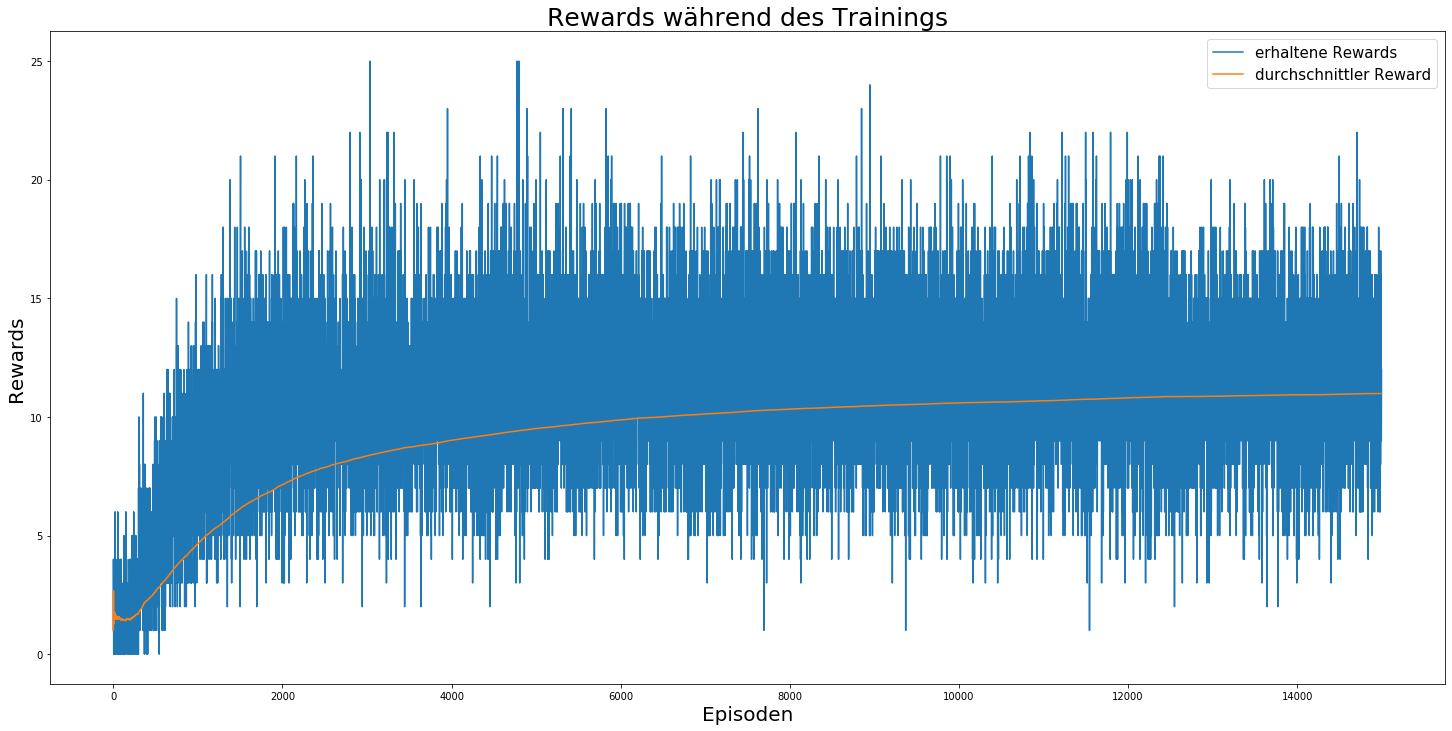

In [26]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [27]:
!ls "WEIGHTS/"

Breakout-v0_DQN_End.h5	    Breakout-v0_DQN_Ep_1984.h5
Breakout-v0_DQN_Ep_1139.h5  Breakout-v0_DQN_Ep_1985.h5
Breakout-v0_DQN_Ep_1512.h5  Breakout-v0_DQN_Ep_2810.h5
Breakout-v0_DQN_Ep_1728.h5  Breakout-v0_DQN_Ep_4641.h5


In [ ]:
# Gewichte laden
WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
DQN.load_weights(filepath=WEIGHTS_PATH)

## Rendering a Game

In [ ]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)